# Imports and Configuration


In [14]:
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

from sklearn.model_selection import train_test_split
from transformers import (
    RobertaModel,
    AutoTokenizer,
    RobertaTokenizer,AutoModelForSequenceClassification
)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import the dataset loader
from mamkit.data.datasets import MMUSEDFallacy, InputMode

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define constants
MAX_TEXT_LEN = 128   # Maximum number of tokens for text
BATCH_SIZE = 16       
NUM_CLASSES = 6
LEARNING_RATE = 2e-5
EPOCHS = 10
SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Define fallacy mapping for easier reference
fallacy_mapping = {
    0: "Appeal to Emotion",
    1: "Appeal to Authority",
    2: "Ad Hominem",
    3: "False Cause",
    4: "Slippery Slope",
    5: "Slogans"
}

Using device: cuda


# Load Dataset


In [15]:
# Load Dataset
base_data_path = Path(os.getcwd()).joinpath('../testdataset')
base_data_path.mkdir(parents=True, exist_ok=True)

# MM-USED-fallacy dataset with text only
mm_used_fallacy_loader = MMUSEDFallacy(
    task_name='afc',  # Argumentative Fallacy Classification
    input_mode=InputMode.TEXT_ONLY,  # Using only text
    base_data_path=base_data_path
)

# Load the Models

# Examining the Dataset

In [16]:
df = mm_used_fallacy_loader.data
print(f"Dataset size: {len(df)} samples")
print(df)
print(df.columns)

Building AFC Context: 100%|██████████| 3388/3388 [00:00<00:00, 13442.57it/s]


Dataset size: 3388 samples
        dialogue_indexes                                 dialogue_sentences  \
0           [84, 85, 86]  [These people depend upon all of us for the li...   
1        [146, 147, 148]  [In mine, I happen to believe in the people an...   
2        [143, 144, 145]  [And, incidentally, I might say that with rega...   
3        [228, 229, 230]  [All history tells us that that's a mistake., ...   
4        [294, 295, 296]  [They see this tremendous influx and swamping ...   
...                  ...                                                ...   
3383  [1068, 1069, 1070]  [We have wars going on with Russia and Ukraine...   
3384  [1069, 1070, 1071]  [We're going to end up in a Third World War, a...   
3385  [1070, 1071, 1072]  [I rebuilt our entire military., She gave a lo...   
3386  [1071, 1072, 1073]  [She gave a lot of it away to the Taliban., Sh...   
3387  [1072, 1073, 1074]  [She gave it to Afghanistan., What these peopl...   

                        

C:\Users\CPInS-01\AppData\Local\Temp\ipykernel_23436\2655930280.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fallacy'] = df['fallacy'].astype(int)


Number of unique dialouges: 37
Number of None/NaN values in fallacy column: 2160
Dataset size after removing None values: 1228 samples

Fallacy class distribution:
  Appeal to Emotion: 757 samples (61.6%)
  Appeal to Authority: 190 samples (15.5%)
  Ad Hominem: 145 samples (11.8%)
  False Cause: 56 samples (4.6%)
  Slippery Slope: 46 samples (3.7%)
  Slogans: 34 samples (2.8%)


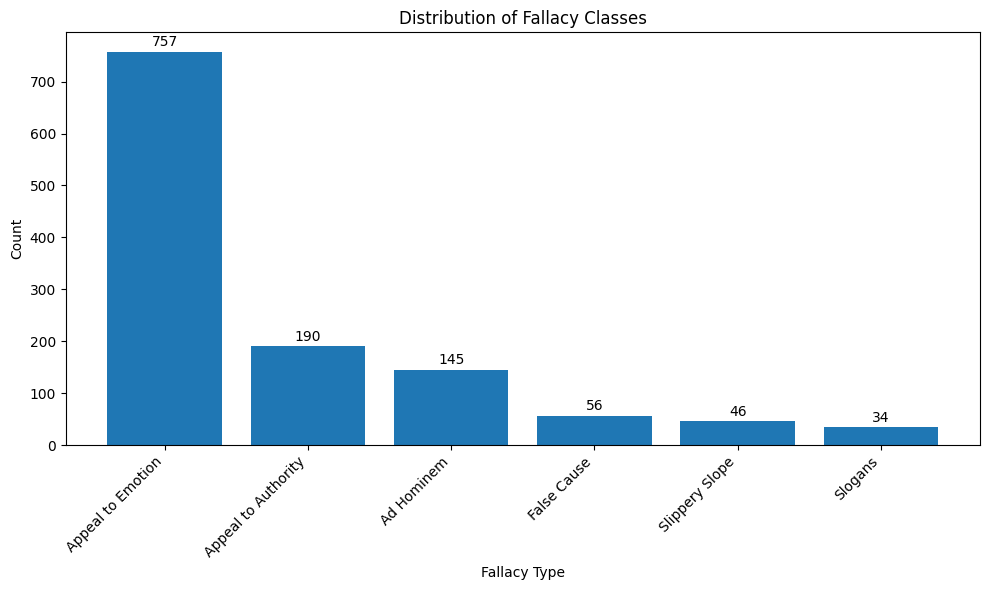

In [17]:

# Get the data

print(f"Number of unique dialouges: {df['dialogue_id'].nunique()}")

# Remove any None values from the fallacy column
print(f"Number of None/NaN values in fallacy column: {df['fallacy'].isna().sum()}")
df = df.dropna(subset=['fallacy'])
print(f"Dataset size after removing None values: {len(df)} samples")

# Ensure fallacy column is integer type
df['fallacy'] = df['fallacy'].astype(int)

# Get the class distribution
fallacy_counts = df['fallacy'].value_counts().sort_index()
print("\nFallacy class distribution:")
for fallacy_id, count in fallacy_counts.items():
    print(f"  {fallacy_mapping[fallacy_id]}: {count} samples ({count/len(df)*100:.1f}%)")

# Visualize fallacy distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(
    [fallacy_mapping[i] for i in fallacy_counts.index], 
    fallacy_counts.values
)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 5,
        f'{height}',
        ha='center', 
        va='bottom'
    )

plt.title('Distribution of Fallacy Classes')
plt.xlabel('Fallacy Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
split_info = mm_used_fallacy_loader.get_splits('mm-argfallacy-2025')[0]

# Step 3: Convert datasets (UnimodalDataset) to DataFrames
def dataset_to_df(dataset):
    return pd.DataFrame({
        "text": dataset.inputs,
        "label": dataset.labels,
    })

train_df = dataset_to_df(split_info.train)
val_df = dataset_to_df(split_info.val)
test_df = dataset_to_df(split_info.test)

# Get the first training sample
# First 5 samples
print(train_df.iloc[:5])


                                                text label
0  And there are other ways of squeezing this bud...     0
1  And you let those people go with the guideline...     0
2  In mine, I happen to believe in the people and...     1
3  That's why faith in the United States is pure ...     0
4  They know that these toxic waste dumps should ...     0


In [19]:
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd

# First: split into train (80%) and temp (20% for val+test)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    train_df["text"].tolist(),
    train_df["label"].tolist(),
    test_size=0.2,
    random_state=SEED,
    stratify=train_df["label"]
)

# Then: split temp into val (10%) and test (10%)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=SEED,
    stratify=temp_labels
)

# Print class distributions
print("Class distribution in Train:", Counter(train_labels))
print("Class distribution in Val:  ", Counter(val_labels))
print("Class distribution in Test: ", Counter(test_labels))


Class distribution in Train: Counter({0: 605, 1: 152, 2: 116, 3: 45, 4: 37, 5: 27})
Class distribution in Val:   Counter({0: 76, 1: 19, 2: 14, 3: 6, 4: 4, 5: 4})
Class distribution in Test:  Counter({0: 76, 1: 19, 2: 15, 3: 5, 4: 5, 5: 3})


In [20]:
# Add 50 Slogans fallacy examples to your dataset
slogan_examples = [
    "America deserves better.",
    "A stronger tomorrow starts today.",
    "Leadership you can trust.",
    "Putting people first.",
    "One nation, one future.",
    "Change you can believe in.",
    "Real solutions for real problems.",
    "Prosperity for all.",
    "It’s time to take back our country.",
    "Hope is not a strategy.",
    "The power of the people is stronger than the people in power.",
    "A fair shot for every child.",
    "Faith, family, freedom.",
    "Because every life counts.",
    "Secure the border, protect the dream.",
    "Standing tall for our values.",
    "Stronger together.",
    "Power to the people.",
    "Defend the dream.",
    "Rebuild. Restore. Renew.",
    "Opportunity, not oppression.",
    "Every voice matters.",
    "Common sense for the common good.",
    "Bringing America back.",
    "Keeping the American promise.",
    "Liberty and justice for all.",
    "Believe in better.",
    "Your future. Your choice.",
    "Take the lead, shape the future.",
    "Working for you.",
    "Courage to change.",
    "For the people, not the powerful.",
    "Building bridges, not walls.",
    "Let freedom ring.",
    "This is our moment.",
    "America first, always.",
    "Strong families. Strong country.",
    "Our future is worth fighting for.",
    "More jobs, less government.",
    "Together, we rise.",
    "The right choice for real change.",
    "Jobs. Freedom. Security.",
    "New energy for a new era.",
    "Your voice. Your vote.",
    "No more politics as usual.",
    "We fight for truth.",
    "A stronger America starts here.",
    "From many, one.",
    "No excuses. Just results.",
    "Rise up for what's right."
]
new_labels = [5] * len(slogan_examples)

# Add to existing arrays
train_texts.extend(slogan_examples)
train_labels.extend(new_labels)

In [21]:
# 1. Augmented slogans (label 5 = "Slogans")
new_slogans = [
    "Together, we can do the impossible.",
    "This is not just a policy, it's a promise.",
    "America deserves better.",
    "Believe in the dream, achieve the impossible.",
    "Let the change begin today.",
    "Justice will prevail, always.",
    "Our future is now.",
    "We stand strong, we stand united.",
    "Hope. Progress. Victory.",
    "A better tomorrow starts with us.",
    "In unity, we find strength.",
    "This is the dawn of a new era.",
    "It's not just politics, it's personal.",
    "Because your voice matters.",
    "The will of the people cannot be ignored.",
    "No more excuses. It's time to act.",
    "Power to the people.",
    "For the many, not the few.",
    "Let's take back our future.",
    "Courage. Character. Commitment.",
    "A vision for every generation.",
    "The heart of the nation beats stronger together.",
    "Freedom isn't free, but it's worth fighting for.",
    "One country. One destiny.",
    "It’s not about left or right, it’s about moving forward.",
    "Stronger families, stronger nation.",
    "Lead with hope, not fear.",
    "We are the change we've been waiting for.",
    "Truth. Trust. Transformation.",
    "Your dreams are our mission."
]

new_labels = [5] * len(new_slogans)

# Add to existing arrays
train_texts.extend(new_slogans)
train_labels.extend(new_labels)

print(f"✅ Updated train_texts: {len(train_texts)} entries")
print(f"✅ Updated train_labels: {len(train_labels)} entries")


✅ Updated train_texts: 1062 entries
✅ Updated train_labels: 1062 entries


In [22]:
# ad_hominem_examples = [
#     "My opponent can't possibly make good decisions about the economy; he has filed for bankruptcy before.",
#     "Why should we listen to the coach's strategy? He was never even a good player!",
#     "You can't talk about conservation if you're not a vegan.",
#     "Your opinion on the matter doesn't count; you only have 50 followers.",
#     "Why should we listen to your ideas for the group project? You got a C on the last assignment.",
#     "You're not a good Christian, so your points about morality are invalid.",
#     "We shouldn't take her suggestions seriously. She's new here.",
#     "How can you give me health advice? You're overweight.",
#     "He doesn't have a Ph.D., so his findings on climate change are worthless.",
#     "He can't be a good musician; he was trained as an engineer.",
#     "Her movie reviews can't be trusted; she liked that film everyone hates.",
#     "You didn't even finish high school, so what would you know about literature?",
#     "You own a leather jacket, so you can't argue for animal rights.",
#     "A man can't have an opinion on women's rights.",
#     "He's single; what does he know about relationships?",
#     "You don't have kids, so your ideas about parenting are irrelevant.",
#     "She's old, so what would she know about smartphones?",
#     "He's not even a lawyer; why would we listen to him about the legal system?",
#     "He dropped out of college, so he can't be trusted to talk about history.",
#     "How can you support environmentalism when you drive an SUV?",
#     "Woody Allen's films are terrible because his adopted daughter accused him of abuse.",
#     "You must be gay or lesbian because you support gay marriage.",
#     "You're not African-American, so you have no right to have an opinion about #BlackLivesMatter.",
#     "Are you sure you didn't consent to have sex with Mr. Hadley? You were dressed very provocatively that night.",
#     "Bill claims that this was an accident, but we know Bill to be a liar, so we can't take his word for it.",
#     "Susan is an avid hunter; therefore, she cannot possibly support gun control.",
#     "Alex: I think we should increase federal spending on education. Bob: You're a fascist, so clearly we shouldn't listen to what you have to say about education.",
#     "Alex: I think we should increase federal spending on education. Bob: You're only saying that because you want to show support for the president you voted for.",
#     "Alex: I think we should increase federal spending on education. Bob: You clearly don't even care about public education since you sent your own kids to a private school.",
#     "Alex: I think we should increase federal spending on education. Bob: Well, the Nazis also thought that, so you're like the Nazis.",
#     "Alex: I think that as a country, we're not spending enough on education. Bob: Well, if you don't like it here, then you should just leave and go somewhere where they have the kind of education that you want.",
#     "Alex: I think we should increase federal spending on education. Bob: Okay, okay, no need to get so worked up over these things.",
#     "You're clearly too young to understand the importance of tradition.",
#     "You don’t understand marriage—you're divorced.",
#     "You’re not a patriot because you criticize the government.",
#     "You’re only supporting that policy because your dad is rich.",
#     "You're saying that because you're just a bleeding-heart liberal.",
#     "You can't possibly understand poverty—you grew up wealthy.",
#     "Why are you lecturing me on mental health when you're clearly unstable?",
#     "Oh please, you only care about the environment when it’s convenient for you.",
#     "He’s just a keyboard warrior, ignore his opinion.",
#     "You're not a scientist, so your view on COVID is irrelevant.",
#     "She's always been emotional—no surprise she's against this policy.",
#     "Don’t listen to him; he got fired from his last job.",
#     "He’s a known atheist, of course he doesn't care about family values.",
#     "She only supports that movement because she's trying to be trendy.",
#     "You were in jail once—your thoughts on prison reform are biased.",
#     "You cheated in college, so don’t talk about academic honesty.",
#     "You used to smoke; your argument against cigarettes is hypocritical.",
#     "That guy lives in his mom’s basement; why would we listen to him?",
#     "He’s just doing this to get attention, not because he believes it.",
# ]
# # Add label 2 for Ad Hominem
# new_labels_ad_hominem = [2] * len(ad_hominem_examples)

# # Append to training data
# train_texts.extend(ad_hominem_examples)
# train_labels.extend(new_labels_ad_hominem)




In [23]:
# 50 examples of False Cause fallacies (text + label)
false_cause_examples = [
    "Ever since we started the new recycling program, the local crime rate has dropped. Clearly, recycling makes our city safer.",
    "The economy improved after I started wearing my lucky tie to work. That tie must be good luck.",
    "Sales have gone up since we painted the office walls blue. The color must be making employees more productive.",
    "After we hired a new janitor, employee satisfaction increased. He must be the reason for happier workers.",
    "Since switching to biodegradable cups, customer complaints have decreased. The cups must be the reason.",
    "Once we installed solar panels, our employee turnover dropped. Clearly, green energy keeps people around.",
    "Since I got my promotion, traffic on my commute has improved. I must be lucky for the city.",
    "After we introduced free coffee, our tech systems have crashed less often. Coffee must boost server stability.",
    "We passed a new dress code and productivity went up. The dress code clearly caused it.",
    "Since we started giving out bonuses, flu cases have decreased. Bonuses must improve health.",
    "After the mayor took office, the sports team started winning. The mayor is clearly bringing good luck.",
    "Once we stopped printing memos, office fires declined. Memos were clearly a fire hazard.",
    "Ever since we bought ergonomic chairs, fewer people are late. The chairs must boost punctuality.",
    "Since we added a foosball table to the break room, profits rose. It's working!",
    "The budget improved after we fired our receptionist. She must have been draining the economy.",
    "We changed our logo and our stock prices climbed. That design must be magic.",
    "After launching the new app, winter was milder. The app is saving the planet!",
    "Crime increased right after that movie was released. The movie must be to blame.",
    "After that senator took office, gas prices skyrocketed. Coincidence? I think not.",
    "We passed a sugar tax and car accidents declined. Clearly, taxing sugar saves lives.",
    "The national anthem was changed, and inflation went down. The anthem must have economic power.",
    "After cutting library hours, unemployment decreased. Maybe people are working instead of reading.",
    "We upgraded the cafeteria menu, and national test scores improved. Healthy food is the key.",
    "Once we banned plastic straws, graduation rates went up. Plastic straws must hinder education.",
    "Since we held a wellness seminar, no earthquakes have hit. We're clearly preventing disasters.",
    "We implemented a new HR policy, and a rival company went bankrupt. Our policy is too strong!",
    "After installing speed bumps, local students started scoring higher in math. Coincidence? Doubtful.",
    "We added a diversity workshop, and quarterly revenue increased. Inclusion drives income.",
    "The government changed its flag, and wildfires decreased. Symbolism must work.",
    "Since we promoted remote work, rainfall has been lighter. Telecommuting affects weather now?",
    "A new textbook was released, and power outages became less frequent. Must be an enlightened grid.",
    "We introduced dress-down Fridays, and energy bills dropped. Jeans are energy efficient.",
    "After increasing vacation days, fewer natural disasters were reported. Rest must balance nature.",
    "Since we banned soda in schools, the GDP grew. Bubbly drinks were holding us back.",
    "After closing several libraries, test scores went up. Maybe less reading helps students focus.",
    "The President started jogging every morning, and the stock market surged. Fitness fuels finance.",
    "Once the national bird was changed, exports increased. A bird-brained economic boom.",
    "After canceling a TV show, crime rates declined. That show was clearly a bad influence.",
    "They installed new streetlights, and divorce rates dropped. Lighting saves marriages.",
    "After introducing electric buses, public speeches became more passionate. Electric energy, literally.",
    "Since the policy change, wild animal sightings have decreased. Government efficiency at work!",
    "We upgraded the website and the birth rate increased. A modern design is irresistible.",
    "After banning plastic bags, rainfall increased. Nature is grateful.",
    "We added more bike lanes, and the literacy rate went up. Bikes and books go hand in hand.",
    "Since changing the national anthem tempo, forest fires have dropped. Rhythm restores nature.",
    "Ever since switching fonts in the constitution, fewer people have moved abroad. Typography matters.",
    "After approving a new textbook, average sleep quality improved. Knowledge brings rest.",
    "They cleaned a river last month, and new startups emerged. Clean water, clean innovation.",
    "After switching government email servers, the ozone layer improved. Digital change saves Earth.",
    "Since adopting the new anthem, fewer volcanoes have erupted. It’s that powerful.",
    "Ever since the prime minister changed their hairstyle, unemployment dropped. Good hair, good economy."
]
# Add label 2 for Ad Hominem
new_labelsfalse_cause_examples = [3] * len(false_cause_examples)

# Append to training data
train_texts.extend(false_cause_examples)
train_labels.extend(new_labelsfalse_cause_examples)

In [24]:
new_slippery_slope_examples = [
    "If we allow students to redo assignments, soon they’ll expect to retake entire courses.",
    "If we legalize marijuana, next we’ll be legalizing all drugs.",
    "Allowing one exception to the rule means soon there will be no rules at all.",
    "If we raise taxes on the rich, soon no one will want to work hard.",
    "If we allow one statue to be taken down, they’ll want to erase all of history.",
    "If we let one child skip the vaccine, disease will spread uncontrollably.",
    "If we don’t discipline this employee, the whole team will become lazy.",
    "If we pass this law, it will open the floodgates to government overreach.",
    "Letting them protest now will lead to total social unrest.",
    "If we ban sugary drinks, next they'll ban fast food entirely.",
    "If we allow online voting, next we’ll eliminate in-person voting altogether.",
    "If we allow this book in schools, soon we’ll be teaching dangerous ideologies.",
    "If we tolerate this kind of speech, hate will spread everywhere.",
    "If we give this group special rights, everyone will demand them.",
    "If we don't punish this behavior harshly, crime will skyrocket.",
    "If we let them build a mall here, it’ll destroy the whole community.",
    "If we approve this spending, we'll go bankrupt as a nation.",
    "If we let kids use calculators, they’ll forget how to do math.",
    "If we let them skip one homework, they’ll never do homework again.",
    "If we allow people to work remotely, no one will come to the office.",
    "If we let one religious group display symbols, every group will demand equal space.",
    "If we increase minimum wage, companies will fire workers and automate everything.",
    "If we forgive one debt, everyone will want their debts erased.",
    "If we open our borders slightly, we'll have no control over immigration.",
    "If we fund this art project, we'll be forced to fund every controversial piece.",
    "If we allow pets in the office, next we’ll be running a zoo.",
    "If we let people work 4-day weeks, productivity will collapse.",
    "If we allow this startup to compete, monopolies will fall and chaos will ensue.",
    "If we stop using fossil fuels, our entire economy will collapse.",
    "If we don’t regulate AI now, robots will take over society.",
    "If we pass this healthcare bill, soon we’ll have full-blown socialism.",
    "If we elect this candidate, they’ll ruin the country in four years.",
    "If we don't act immediately, climate change will destroy all life.",
    "If we allow phone use in class, students won’t pay attention ever again.",
    "If we allow this trend to continue, traditional values will vanish completely.",
    "If we accept late applications, we’ll lose all control of deadlines.",
    "If we compromise on this issue, we’ll have to compromise on everything.",
    "If we allow self-driving cars, human drivers will become obsolete.",
    "If we don’t arrest this protestor, society will break down.",
    "If we let them rewrite the curriculum, they’ll rewrite history.",
    "If we allow one gun regulation, it’s the start of gun confiscation.",
    "If we give in to this demand, they’ll never stop asking for more.",
    "If we let this policy pass, every state will have to follow suit.",
    "If we remove this restriction, people will abuse the system.",
    "If we stop checking IDs at the door, anyone could sneak in.",
    "If we let her skip a grade, all parents will demand it for their kids.",
    "If we allow animal rights to dictate policy, we’ll all be vegans by law.",
    "If we let robots teach, human teachers will lose their jobs.",
    "If we approve this merger, soon all companies will consolidate into one.",
    "If we let one criminal go free, justice will lose all meaning."
]
new_labels = [4] * len(new_slippery_slope_examples)
train_texts.extend(new_slippery_slope_examples)
train_labels.extend(new_labels)

In [25]:
ad_hominem_examples = [
    "My opponent's stance on healthcare is irrelevant; remember, he was caught lying about his education.",
    "She advocates for environmental policies, but she flies on private jets regularly.",
    "Don't trust his economic plan; he filed for bankruptcy twice.",
    "He talks about family values, yet he's been divorced three times.",
    "Her opinion on education reform shouldn't matter; she never attended public school.",
    "He supports tax increases, but he was caught evading taxes last year.",
    "Why listen to her on military matters? She never served a day in the armed forces.",
    "He can't be serious about healthcare; he's overweight and out of shape.",
    "She argues for gun control, but she owns multiple firearms herself.",
    "His views on immigration are invalid; he's the child of immigrants.",
    "She promotes women's rights, but she once made sexist remarks herself.",
    "Don't take his climate change arguments seriously; he drives a gas-guzzling SUV.",
    "He talks about honesty in politics, yet he was involved in a plagiarism scandal.",
    "Her stance on education is flawed; she was a terrible student.",
    "He supports welfare programs, but he comes from a wealthy family.",
    "She criticizes corporate greed, but she owns significant stock in major corporations.",
    "His foreign policy ideas are naive; he has no international experience.",
    "She advocates for LGBTQ+ rights, but she once opposed same-sex marriage.",
    "Don't believe his fiscal responsibility talk; he mismanaged his own company's finances.",
    "She speaks on public health, but she refuses to vaccinate her children.",
    "He promotes transparency, yet he deleted thousands of his emails.",
    "Her views on policing are biased; her brother is a police officer.",
    "He argues for prison reform, but he has a criminal record himself.",
    "She supports freedom of speech, but she once tried to censor a journalist.",
    "His environmental policies can't be trusted; he invested in oil companies.",
    "She talks about affordable housing, but she owns multiple luxury apartments.",
    "He advocates for student loan forgiveness, yet he paid off his loans early.",
    "She supports labor unions, but she laid off workers without notice.",
    "His healthcare plan is questionable; he has no medical background.",
    "She criticizes government spending, but she approved a costly project.",
    "He talks about unity, yet he made divisive comments in the past.",
    "Her stance on drug policy is invalid; she admitted to past drug use.",
    "He promotes digital privacy, but he was involved in a data breach scandal.",
    "She supports veterans, but she voted against veteran benefits.",
    "His education policy is flawed; he dropped out of college.",
    "She talks about ethics, yet she accepted gifts from lobbyists.",
    "He advocates for public transportation, but he commutes by helicopter.",
    "She supports small businesses, but she sued a local shop over a minor issue.",
    "His views on taxation are hypocritical; he keeps his money in offshore accounts.",
    "She promotes healthy eating, but she owns a fast-food franchise.",
    "He talks about national security, yet he leaked confidential information.",
    "She supports arts funding, but she cut the budget for local theaters.",
    "His stance on agriculture is questionable; he has never visited a farm.",
    "She advocates for mental health, but she mocked a colleague's therapy sessions.",
    "He supports police reform, but he once called for harsher penalties.",
    "She talks about internet freedom, yet she supported censorship laws.",
    "His views on housing are invalid; he lives in a mansion.",
    "She promotes education, but she sends her children to private schools.",
    "He supports renewable energy, but he invested in coal companies.",
    "She talks about public service, yet she missed numerous council meetings.",
    "His stance on youth programs is flawed; he has no children.",
    "She advocates for animal rights, but she wears fur coats.",
]
# Assuming Ad Hominem has label 2 in your dataset
new_labels = [2] * len(ad_hominem_examples)

# Append the new examples to your training data
train_texts.extend(ad_hominem_examples)
train_labels.extend(new_labels)

print(f"Added {len(ad_hominem_examples)} new Ad Hominem examples.")
print(f"Total training samples now: {len(train_texts)}")
# new_ad_hominem = [
#     "Of course he supports that policy — he's never had to work a real job in his life.",
#     "I wouldn't trust her opinion on healthcare; she can’t even take care of her own family.",
#     "You’re going to believe someone who lied about their college degree?",
#     "Naturally, he opposes tax reform — he’s been evading taxes for years.",
#     "She’s criticizing our economic plan, but her company went bankrupt twice.",
#     "That’s coming from someone who’s never served their country a day in their life.",
#     "Only a hypocrite like him would pretend to care about the environment while flying private jets.",
#     "Before we even listen to him, remember he was caught plagiarizing his speech last year.",
#     "She claims to care about education, but her record shows she cut school funding repeatedly.",
#     "How can you trust a man who can’t stay loyal to his own spouse?",
#     "He wants to lead the country? He can’t even manage his own finances.",
#     "That argument is weak, especially coming from someone who failed their last three campaigns.",
#     "We shouldn’t listen to her; she flip-flops constantly.",
#     "Why would we take advice from someone who’s been under ethics investigation multiple times?",
#     "Let’s not forget, the last time he was in charge, there were multiple corruption scandals."
# ]

# new_labels_ad_hominem = [2] * len(new_ad_hominem)

# train_texts.extend(new_ad_hominem)
# train_labels.extend(new_labels_ad_hominem)

# print("Added", len(new_ad_hominem), "new Ad Hominem examples.")
# print("Total training samples now:", len(train_texts))


Added 52 new Ad Hominem examples.
Total training samples now: 1215


In [28]:
# Create a combined DataFrame with all the augmented examples and original data
import pandas as pd

# Collect all augmented examples
augmented_data = []

# Original slogans
for text, label in zip(slogan_examples, [5] * len(slogan_examples)):
    augmented_data.append({
        "text": text,
        "label": fallacy_mapping[5]
    })

# New slogans
for text, label in zip(new_slogans, [5] * len(new_slogans)):
    augmented_data.append({
        "text": text,
        "label": fallacy_mapping[5]
    })

# False Cause examples
for text, label in zip(false_cause_examples, [3] * len(false_cause_examples)):
    augmented_data.append({
        "text": text,
        "label": fallacy_mapping[3]
    })

# Slippery Slope examples
for text, label in zip(new_slippery_slope_examples, [4] * len(new_slippery_slope_examples)):
    augmented_data.append({
        "text": text,
        "label": fallacy_mapping[4]
    })

# Ad Hominem examples
for text, label in zip(ad_hominem_examples, [2] * len(ad_hominem_examples)):
    augmented_data.append({
        "text": text,
        "label": fallacy_mapping[2]
    })

# Create DataFrame from all augmented examples
augmented_df = pd.DataFrame(augmented_data)

# Save to CSV
csv_path = "augmented_fallacy_examples.csv"
augmented_df.to_csv(csv_path, index=False)

print(f"Saved {len(augmented_df)} augmented examples to {csv_path}")

# Display summary of the augmented dataset
summary = augmented_df.groupby(["label"]).size().reset_index(name="count")
print("\nAugmented examples summary:")
print(summary)

Saved 233 augmented examples to augmented_fallacy_examples.csv

Augmented examples summary:
            label  count
0      Ad Hominem     52
1     False Cause     51
2  Slippery Slope     50
3         Slogans     80


In [83]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")


def tokenize(texts):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=MAX_TEXT_LEN,
        return_tensors="pt"
    )

In [84]:
class FallacyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        encodings = tokenize(texts)
        self.input_ids = encodings["input_ids"]
        self.attention_mask = encodings["attention_mask"]
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }


In [85]:

train_dataset = FallacyDataset(train_texts, train_labels, tokenizer)
val_dataset = FallacyDataset(val_texts, val_labels, tokenizer)
test_dataset = FallacyDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [86]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=NUM_CLASSES,ignore_mismatched_sizes=True
).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
# Get all training labels
all_train_labels = train_labels  # already a list

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_train_labels),
    y=all_train_labels
)

# Convert to a torch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.3347, 1.3322, 1.2054, 2.1094, 2.3276, 1.8925], device='cuda:0')


In [88]:
from transformers import AdamW, get_scheduler

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

num_training_steps = EPOCHS * len(train_loader)

lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


d:\newargmining\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [89]:
from tqdm import tqdm

def train_epoch(model, data_loader, optimizer, criterion, scheduler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            
            # Collecting predictions and labels for metrics calculation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss
    avg_loss = total_loss / len(data_loader)
    
    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    micro_f1 = f1_score(all_labels, all_preds, average='micro')
    precision_macro = precision_score(all_labels, all_preds, average='macro')
    recall_macro = recall_score(all_labels, all_preds, average='macro')
    
    # Generate detailed classification report
    class_report = classification_report(all_labels, all_preds, digits=4)
    
    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'micro_f1': micro_f1,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'classification_report': class_report
    }
    
    return metrics


In [90]:
# def evaluate(model, data_loader, criterion, id2label=None):
#     model.eval()
#     total_loss = 0
#     correct = 0
#     total = 0
#     all_preds = []
#     all_labels = []
    
#     # Initialize counters for each class
#     class_counts = {}
#     class_correct = {}
    
#     with torch.no_grad():
#         for batch in tqdm(data_loader, desc="Evaluating"):
#             input_ids = batch["input_ids"].to(device)
#             attention_mask = batch["attention_mask"].to(device)
#             labels = batch["labels"].to(device)
            
#             # Get the original texts for printing
#             texts = batch.get("texts", tokenizer.batch_decode(input_ids, skip_special_tokens=True))
            
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             logits = outputs.logits
            
#             total_loss += loss.item()
#             preds = torch.argmax(logits, dim=1)
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)
            
#             # Print input text, predicted class, and actual class
#             for i in range(len(preds)):
#                 pred_label = id2label[preds[i].item()] if id2label else preds[i].item()
#                 true_label = id2label[labels[i].item()] if id2label else labels[i].item()
#                 text = texts[i] if isinstance(texts, list) else texts
                
#                 # Count for class statistics
#                 true_class = labels[i].item()
#                 if true_class not in class_counts:
#                     class_counts[true_class] = 0
#                     class_correct[true_class] = 0
#                 class_counts[true_class] += 1
#                 if preds[i].item() == true_class:
#                     class_correct[true_class] += 1
                
#                 print(f"Text: {text[:100]}{'...' if len(text) > 100 else ''}")
#                 print(f"Predicted: {pred_label}, Actual: {true_label}")
#                 print("-" * 50)
            
#             # Store predictions and labels for metrics
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     # Print class-wise statistics
#     print("\n--- Class Statistics ---")
#     for class_id in sorted(class_counts.keys()):
#         class_name = id2label[class_id] if id2label else f"Class {class_id}"
#         class_accuracy = class_correct[class_id] / class_counts[class_id] if class_counts[class_id] > 0 else 0
#         print(f"{class_name}: {class_correct[class_id]}/{class_counts[class_id]} correct ({class_accuracy:.2%})")
    
#     print(f"\nTotal samples: {total}")
#     print(f"Total correct: {correct}")
#     print(f"Overall accuracy: {correct/total:.2%}")

#     avg_loss = total_loss / len(data_loader)
#     accuracy = correct / total
#     return avg_loss, accuracy, all_preds, all_labels

Lr= 2e5

In [91]:
for epoch in range(EPOCHS):
    print(f"\n🌟 Epoch {epoch + 1}/{EPOCHS}")
    
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, lr_scheduler)
    evaluation_results = evaluate(model, train_loader, criterion)
    print(f"Train Loss: {evaluation_results['loss']:.4f}")
    print(f"Train Accuracy: {evaluation_results['accuracy']:.4f}")
    print(f"Train Macro F1: {evaluation_results['macro_f1']:.4f}")
    print(f"Train Micro F1: {evaluation_results['micro_f1']:.4f}")
    print(f"Train Classification Report:\n{evaluation_results['classification_report']}")
    
    evaluation_results = evaluate(model, val_loader, criterion)
    print(f"Loss: {evaluation_results['loss']:.4f}")
    print(f"Accuracy: {evaluation_results['accuracy']:.4f}")
    print(f"Macro F1: {evaluation_results['macro_f1']:.4f}")
    print(f"Micro F1: {evaluation_results['micro_f1']:.4f}")
    print(f"Classification Report:\n{evaluation_results['classification_report']}")


🌟 Epoch 1/10


Evaluating: 100%|██████████| 76/76 [00:04<00:00, 16.32it/s]
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Train Loss: 1.1689
Train Accuracy: 0.5506
Train Macro F1: 0.2079
Train Micro F1: 0.5506
Train Classification Report:
              precision    recall  f1-score   support

           0     0.5256    1.0000    0.6891       605
           1     1.0000    0.0066    0.0131       152
           2     1.0000    0.3750    0.5455       168
           3     0.0000    0.0000    0.0000        96
           4     0.0000    0.0000    0.0000        87
           5     0.0000    0.0000    0.0000       107

    accuracy                         0.5506      1215
   macro avg     0.4209    0.2303    0.2079      1215
weighted avg     0.5251    0.5506    0.4202      1215



Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.89it/s]
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

Loss: 1.1637
Accuracy: 0.6260
Macro F1: 0.1502
Micro F1: 0.6260
Classification Report:
              precision    recall  f1-score   support

           0     0.6230    1.0000    0.7677        76
           1     0.0000    0.0000    0.0000        19
           2     1.0000    0.0714    0.1333        14
           3     0.0000    0.0000    0.0000         6
           4     0.0000    0.0000    0.0000         4
           5     0.0000    0.0000    0.0000         4

    accuracy                         0.6260       123
   macro avg     0.2705    0.1786    0.1502       123
weighted avg     0.4987    0.6260    0.4895       123


🌟 Epoch 2/10


Evaluating: 100%|██████████| 76/76 [00:04<00:00, 16.23it/s]


Train Loss: 0.5029
Train Accuracy: 0.8527
Train Macro F1: 0.8374
Train Micro F1: 0.8527
Train Classification Report:
              precision    recall  f1-score   support

           0     0.8480    0.9405    0.8918       605
           1     0.6619    0.6053    0.6323       152
           2     0.8859    0.7857    0.8328       168
           3     0.9630    0.8125    0.8814        96
           4     0.8929    0.8621    0.8772        87
           5     0.9890    0.8411    0.9091       107

    accuracy                         0.8527      1215
   macro avg     0.8734    0.8079    0.8374      1215
weighted avg     0.8547    0.8527    0.8509      1215



Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.78it/s]
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

Loss: 0.8867
Accuracy: 0.6585
Macro F1: 0.4728
Micro F1: 0.6585
Classification Report:
              precision    recall  f1-score   support

           0     0.7159    0.8289    0.7683        76
           1     0.4211    0.4211    0.4211        19
           2     0.5714    0.2857    0.3810        14
           3     0.7500    0.5000    0.6000         6
           4     0.6000    0.7500    0.6667         4
           5     0.0000    0.0000    0.0000         4

    accuracy                         0.6585       123
   macro avg     0.5097    0.4643    0.4728       123
weighted avg     0.6285    0.6585    0.6341       123


🌟 Epoch 3/10


Evaluating: 100%|██████████| 76/76 [00:04<00:00, 16.22it/s]


Train Loss: 0.2948
Train Accuracy: 0.9160
Train Macro F1: 0.9090
Train Micro F1: 0.9160
Train Classification Report:
              precision    recall  f1-score   support

           0     0.9525    0.9289    0.9406       605
           1     0.7571    0.8816    0.8146       152
           2     0.8674    0.9345    0.8997       168
           3     0.9556    0.8958    0.9247        96
           4     0.9630    0.8966    0.9286        87
           5     1.0000    0.8972    0.9458       107

    accuracy                         0.9160      1215
   macro avg     0.9159    0.9058    0.9090      1215
weighted avg     0.9215    0.9160    0.9175      1215



Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.73it/s]
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

Loss: 0.9401
Accuracy: 0.6585
Macro F1: 0.5253
Micro F1: 0.6585
Classification Report:
              precision    recall  f1-score   support

           0     0.7639    0.7237    0.7432        76
           1     0.4194    0.6842    0.5200        19
           2     0.5833    0.5000    0.5385        14
           3     0.7500    0.5000    0.6000         6
           4     0.7500    0.7500    0.7500         4
           5     0.0000    0.0000    0.0000         4

    accuracy                         0.6585       123
   macro avg     0.5444    0.5263    0.5253       123
weighted avg     0.6641    0.6585    0.6545       123


🌟 Epoch 4/10


Evaluating: 100%|██████████| 76/76 [00:04<00:00, 16.10it/s]


Train Loss: 0.1719
Train Accuracy: 0.9457
Train Macro F1: 0.9407
Train Micro F1: 0.9457
Train Classification Report:
              precision    recall  f1-score   support

           0     0.9810    0.9405    0.9603       605
           1     0.8276    0.9474    0.8834       152
           2     0.9111    0.9762    0.9425       168
           3     0.9192    0.9479    0.9333        96
           4     0.9878    0.9310    0.9586        87
           5     1.0000    0.9346    0.9662       107

    accuracy                         0.9457      1215
   macro avg     0.9378    0.9463    0.9407      1215
weighted avg     0.9494    0.9457    0.9465      1215



Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.41it/s]


Loss: 1.1335
Accuracy: 0.6098
Macro F1: 0.5026
Micro F1: 0.6098
Classification Report:
              precision    recall  f1-score   support

           0     0.7869    0.6316    0.7007        76
           1     0.4333    0.6842    0.5306        19
           2     0.4667    0.5000    0.4828        14
           3     0.3333    0.6667    0.4444         6
           4     1.0000    0.7500    0.8571         4
           5     0.0000    0.0000    0.0000         4

    accuracy                         0.6098       123
   macro avg     0.5034    0.5387    0.5026       123
weighted avg     0.6550    0.6098    0.6194       123


🌟 Epoch 5/10


Evaluating: 100%|██████████| 76/76 [00:04<00:00, 16.00it/s]


Train Loss: 0.0819
Train Accuracy: 0.9827
Train Macro F1: 0.9772
Train Micro F1: 0.9827
Train Classification Report:
              precision    recall  f1-score   support

           0     0.9868    0.9917    0.9893       605
           1     0.9932    0.9671    0.9800       152
           2     0.9600    1.0000    0.9796       168
           3     0.9789    0.9688    0.9738        96
           4     0.9651    0.9540    0.9595        87
           5     1.0000    0.9626    0.9810       107

    accuracy                         0.9827      1215
   macro avg     0.9807    0.9740    0.9772      1215
weighted avg     0.9829    0.9827    0.9827      1215



Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.52it/s]
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

Loss: 1.0708
Accuracy: 0.6585
Macro F1: 0.4775
Micro F1: 0.6585
Classification Report:
              precision    recall  f1-score   support

           0     0.7808    0.7500    0.7651        76
           1     0.4615    0.6316    0.5333        19
           2     0.5000    0.4286    0.4615        14
           3     0.4444    0.6667    0.5333         6
           4     0.6667    0.5000    0.5714         4
           5     0.0000    0.0000    0.0000         4

    accuracy                         0.6585       123
   macro avg     0.4756    0.4961    0.4775       123
weighted avg     0.6540    0.6585    0.6523       123


🌟 Epoch 6/10


Evaluating: 100%|██████████| 76/76 [00:04<00:00, 16.06it/s]


Train Loss: 0.0549
Train Accuracy: 0.9877
Train Macro F1: 0.9847
Train Micro F1: 0.9877
Train Classification Report:
              precision    recall  f1-score   support

           0     0.9917    0.9917    0.9917       605
           1     0.9868    0.9803    0.9835       152
           2     0.9765    0.9881    0.9822       168
           3     0.9895    0.9792    0.9843        96
           4     0.9767    0.9655    0.9711        87
           5     0.9907    1.0000    0.9953       107

    accuracy                         0.9877      1215
   macro avg     0.9853    0.9841    0.9847      1215
weighted avg     0.9877    0.9877    0.9876      1215



Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.43it/s]


Loss: 1.3484
Accuracy: 0.6098
Macro F1: 0.5064
Micro F1: 0.6098
Classification Report:
              precision    recall  f1-score   support

           0     0.7903    0.6447    0.7101        76
           1     0.3714    0.6842    0.4815        19
           2     0.5455    0.4286    0.4800        14
           3     0.4444    0.6667    0.5333         6
           4     0.5000    0.5000    0.5000         4
           5     0.5000    0.2500    0.3333         4

    accuracy                         0.6098       123
   macro avg     0.5253    0.5290    0.5064       123
weighted avg     0.6620    0.6098    0.6209       123


🌟 Epoch 7/10


Evaluating: 100%|██████████| 76/76 [00:04<00:00, 16.08it/s]


Train Loss: 0.0379
Train Accuracy: 0.9901
Train Macro F1: 0.9891
Train Micro F1: 0.9901
Train Classification Report:
              precision    recall  f1-score   support

           0     0.9967    0.9884    0.9925       605
           1     0.9868    0.9868    0.9868       152
           2     0.9709    0.9940    0.9824       168
           3     0.9897    1.0000    0.9948        96
           4     0.9773    0.9885    0.9829        87
           5     1.0000    0.9907    0.9953       107

    accuracy                         0.9901      1215
   macro avg     0.9869    0.9914    0.9891      1215
weighted avg     0.9902    0.9901    0.9901      1215



Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.71it/s]


Loss: 1.2298
Accuracy: 0.6504
Macro F1: 0.4761
Micro F1: 0.6504
Classification Report:
              precision    recall  f1-score   support

           0     0.7671    0.7368    0.7517        76
           1     0.4615    0.6316    0.5333        19
           2     0.6000    0.4286    0.5000        14
           3     0.5000    0.6667    0.5714         6
           4     0.5000    0.5000    0.5000         4
           5     0.0000    0.0000    0.0000         4

    accuracy                         0.6504       123
   macro avg     0.4714    0.4939    0.4761       123
weighted avg     0.6542    0.6504    0.6479       123


🌟 Epoch 8/10


Evaluating: 100%|██████████| 76/76 [00:04<00:00, 16.14it/s]


Train Loss: 0.0278
Train Accuracy: 0.9909
Train Macro F1: 0.9901
Train Micro F1: 0.9909
Train Classification Report:
              precision    recall  f1-score   support

           0     0.9934    0.9917    0.9926       605
           1     0.9934    0.9868    0.9901       152
           2     0.9766    0.9940    0.9853       168
           3     1.0000    0.9896    0.9948        96
           4     0.9884    0.9770    0.9827        87
           5     0.9907    1.0000    0.9953       107

    accuracy                         0.9909      1215
   macro avg     0.9904    0.9899    0.9901      1215
weighted avg     0.9910    0.9909    0.9910      1215



Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.69it/s]
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\newargmining\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

Loss: 1.2733
Accuracy: 0.6667
Macro F1: 0.4828
Micro F1: 0.6667
Classification Report:
              precision    recall  f1-score   support

           0     0.7500    0.7895    0.7692        76
           1     0.4231    0.5789    0.4889        19
           2     0.6667    0.4286    0.5217        14
           3     0.6000    0.5000    0.5455         6
           4     0.6667    0.5000    0.5714         4
           5     0.0000    0.0000    0.0000         4

    accuracy                         0.6667       123
   macro avg     0.5177    0.4662    0.4828       123
weighted avg     0.6556    0.6667    0.6554       123


🌟 Epoch 9/10


Evaluating: 100%|██████████| 76/76 [00:04<00:00, 16.06it/s]


Train Loss: 0.0246
Train Accuracy: 0.9909
Train Macro F1: 0.9901
Train Micro F1: 0.9909
Train Classification Report:
              precision    recall  f1-score   support

           0     0.9917    0.9934    0.9926       605
           1     0.9934    0.9868    0.9901       152
           2     0.9822    0.9881    0.9852       168
           3     1.0000    0.9896    0.9948        96
           4     0.9884    0.9770    0.9827        87
           5     0.9907    1.0000    0.9953       107

    accuracy                         0.9909      1215
   macro avg     0.9911    0.9892    0.9901      1215
weighted avg     0.9910    0.9909    0.9909      1215



Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.54it/s]


Loss: 1.3258
Accuracy: 0.6585
Macro F1: 0.4828
Micro F1: 0.6585
Classification Report:
              precision    recall  f1-score   support

           0     0.7564    0.7763    0.7662        76
           1     0.4545    0.5263    0.4878        19
           2     0.6000    0.4286    0.5000        14
           3     0.5000    0.6667    0.5714         6
           4     0.6667    0.5000    0.5714         4
           5     0.0000    0.0000    0.0000         4

    accuracy                         0.6585       123
   macro avg     0.4963    0.4830    0.4828       123
weighted avg     0.6520    0.6585    0.6522       123


🌟 Epoch 10/10


Evaluating: 100%|██████████| 76/76 [00:04<00:00, 16.43it/s]


Train Loss: 0.0241
Train Accuracy: 0.9918
Train Macro F1: 0.9912
Train Micro F1: 0.9918
Train Classification Report:
              precision    recall  f1-score   support

           0     0.9950    0.9917    0.9934       605
           1     0.9934    0.9868    0.9901       152
           2     0.9766    0.9940    0.9853       168
           3     1.0000    0.9896    0.9948        96
           4     0.9885    0.9885    0.9885        87
           5     0.9907    1.0000    0.9953       107

    accuracy                         0.9918      1215
   macro avg     0.9907    0.9918    0.9912      1215
weighted avg     0.9918    0.9918    0.9918      1215



Evaluating: 100%|██████████| 8/8 [00:00<00:00, 17.03it/s]

Loss: 1.3538
Accuracy: 0.6748
Macro F1: 0.4950
Micro F1: 0.6748
Classification Report:
              precision    recall  f1-score   support

           0     0.7867    0.7763    0.7815        76
           1     0.4800    0.6316    0.5455        19
           2     0.6000    0.4286    0.5000        14
           3     0.5000    0.6667    0.5714         6
           4     0.6667    0.5000    0.5714         4
           5     0.0000    0.0000    0.0000         4

    accuracy                         0.6748       123
   macro avg     0.5056    0.5005    0.4950       123
weighted avg     0.6746    0.6748    0.6705       123



In [ ]:


evaluation_results = evaluate(model, test_loader, criterion)
print(f"Loss: {evaluation_results['loss']:.4f}")
print(f"Accuracy: {evaluation_results['accuracy']:.4f}")
print(f"Accuracy: {evaluation_results['accuracy']:.4f}")
print(f"Macro F1: {evaluation_results['macro_f1']:.4f}")
print(f"Micro F1: {evaluation_results['micro_f1']:.4f}")
print(f"Classification Report:\n{evaluation_results['classification_report']}")


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.69it/s]

Loss: 1.2053
Accuracy: 0.7236
Macro F1: 0.5786
Micro F1: 0.7236
Classification Report:
              precision    recall  f1-score   support

           0     0.8052    0.8158    0.8105        76
           1     0.7143    0.7895    0.7500        19
           2     0.5000    0.4000    0.4444        15
           3     0.4000    0.4000    0.4000         5
           4     0.4000    0.4000    0.4000         5
           5     0.6667    0.6667    0.6667         3

    accuracy                         0.7236       123
   macro avg     0.5810    0.5787    0.5786       123
weighted avg     0.7176    0.7236    0.7196       123



In [95]:
model.save_pretrained("roberta_aug_final_metrics")
tokenizer.save_pretrained("roberta_aug_final_metrics")


('roberta_aug_final_metrics\\tokenizer_config.json',
 'roberta_aug_final_metrics\\special_tokens_map.json',
 'roberta_aug_final_metrics\\vocab.json',
 'roberta_aug_final_metrics\\merges.txt',
 'roberta_aug_final_metrics\\added_tokens.json',
 'roberta_aug_final_metrics\\tokenizer.json')

Misclassification Analysis by Class
Class 0: Appeal to Emotion (63/76 correct, 82.89%)

Misclassified as Appeal to Authority (Class 1): 7 instances
Misclassified as Ad Hominem (Class 2): 3 instances
Misclassified as False Cause (Class 3): 3 instances

Class 1: Appeal to Authority (13/19 correct, 68.42%)

Misclassified as Appeal to Emotion (Class 0): 4 instances
Misclassified as False Cause (Class 3): 2 instances

Class 2: Ad Hominem (3/15 correct, 20.00%)

Misclassified as Appeal to Emotion (Class 0): 10 instances
Misclassified as Appeal to Authority (Class 1): 2 instances

Class 3: False Cause (1/5 correct, 20.00%)

Misclassified as Appeal to Emotion (Class 0): 3 instances
Misclassified as Appeal to Authority (Class 1): 1 instance

Class 4: Slippery Slope (0/5 correct, 0.00%)

Misclassified as Appeal to Emotion (Class 0): 3 instances
Misclassified as Ad Hominem (Class 2): 2 instances

Class 5: Slogans (1/3 correct, 33.33%)

Misclassified as Appeal to Emotion (Class 0): 2 instances

Key Observations:

Appeal to Emotion (Class 0) acts as a "catch-all" category for the model, with most misclassifications from other classes going to this category.
Ad Hominem (Class 2) is heavily misclassified as Appeal to Emotion (10/15), representing the worst recognition among major classes.
Slippery Slope (Class 4) has a 0% accuracy rate, with most instances misclassified as Appeal to Emotion.